# Random forest running with only VVR_1 and VVR_2

Add description. 

Import libraries. 

In [1]:
# Import necessary libraries
import json
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, auc, precision_recall_curve, confusion_matrix
import pandas as pd
import logging
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import confusion_matrix 
from collections import Counter

# Import data 

In [2]:
# Load the data into pandas dataframes
X_train_12 = pd.read_csv('/Users/dionnespaltman/Desktop/V4/data/X_train_12.csv')
y_train_12 = pd.read_csv('/Users/dionnespaltman/Desktop/V4/data/y_train_12.csv')
X_test_12 = pd.read_csv('/Users/dionnespaltman/Desktop/V4/data/X_test_12.csv')
y_test = pd.read_csv('/Users/dionnespaltman/Desktop/V4/data/y_test.csv')

X_train_12 = X_train_12.drop(columns='Unnamed: 0', axis=1)
y_train_12 = y_train_12.drop(columns='Unnamed: 0', axis=1)
X_test_12 = X_test_12.drop(columns='Unnamed: 0', axis=1)
y_test = y_test.drop(columns='Unnamed: 0', axis=1)

# Display the first few rows of each dataframe to verify the loading
print("X_train_12:")
display(X_train_12.head())

print("\ny_train_12:")
display(y_train_12.head())

print("\nX_test_12:")
display(X_test_12.head())

print("\ny_test:")
# print(y_test)
display(y_test.head())

# Convert the DataFrame to a 1-dimensional NumPy array
y_train_12 = y_train_12.values.ravel()
y_test = y_test.values.ravel()


X_train_12:


,VVR_1,VVR_2
0,12.0,13.0
1,10.0,10.0
2,8.0,8.0
3,10.0,8.0
4,8.0,8.0



y_train_12:


,VVR_group
0,1
1,1
2,0
3,0
4,0



X_test_12:


,VVR_1,VVR_2
0,10.0,11.0
1,19.0,21.0
2,8.0,8.0
3,21.0,21.0
4,11.0,8.0



y_test:


,VVR_group
0,0
1,1
2,0
3,1
4,0


# Model with inner and outer split

https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html 

In [4]:
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# Declare the inner and outer cross-validation strategies
inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=3, shuffle=True, random_state=0)

# Create the pipeline with RFE and the model
# rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=2)
rfe = RFE(estimator=DecisionTreeClassifier())
model = RandomForestClassifier()
pipeline = Pipeline(steps=[('s', rfe), ('m', model)])

param_grid = {
    'm__n_estimators': [100, 200, 300],  # Number of trees in the forest
    'm__class_weight': [{0: 0.6428571428571429, 1: 2.25}, None],  # Class weights
    'm__max_depth': [None, 10, 20],  # Maximum depth of the tree
    # 's__n_features_to_select': [5, 10, 15, 20]  # Number of features to select with RFE
    # 's__n_features_to_select': [5, 10, 20, 40, 60, 80]  # Number of features to select with RFE

}

# Inner cross-validation for parameter search
model = GridSearchCV(
    estimator=pipeline, param_grid=param_grid, cv=inner_cv, n_jobs=2
)

# Outer cross-validation to compute the testing score
test_score = cross_val_score(model, X_train_12, y_train_12, cv=outer_cv, n_jobs=2)
print(
    "The mean score using nested cross-validation is: "
    f"{test_score.mean():.3f} ± {test_score.std():.3f}"
)

# Print shape
print(X_train_12.shape)
print(y_train_12.shape)

# Fit model to training data to get best parameters
model.fit(X_train_12, y_train_12)

# Print best parameters
print(model.best_params_)

# Print the features that were selected with RFE

# Evaluate on the test set
best_model = model.best_estimator_
y_pred = best_model.predict(X_test_12)

# Print shape
print(y_test.shape)
print(y_pred.shape)

# Print classification report 
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

# Calculate and print the AUC-PR
y_proba = best_model.predict_proba(X_test_12)[:, 1]  # Get the probabilities for the positive class
precision, recall, _ = precision_recall_curve(y_test, y_proba)
auc_pr = auc(recall, precision)
print(f"AUC-PR: {auc_pr:.3f}")


# fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=2)
# print(metrics.auc(fpr, tpr))


The mean score using nested cross-validation is: 0.847 ± 0.071
(72, 2)
(72,)
{'m__class_weight': {0: 0.6428571428571429, 1: 2.25}, 'm__max_depth': None, 'm__n_estimators': 100}
(32,)
(32,)

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90        25
           1       0.67      0.57      0.62         7

    accuracy                           0.84        32
   macro avg       0.78      0.75      0.76        32
weighted avg       0.84      0.84      0.84        32

[[23  2]
 [ 3  4]]
AUC-PR: 0.763


# Confusion matrix 

/var/folders/_4/nzq6mygj7j71_l3z_c9kc7wr0000gn/T/ipykernel_3657/2779139778.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


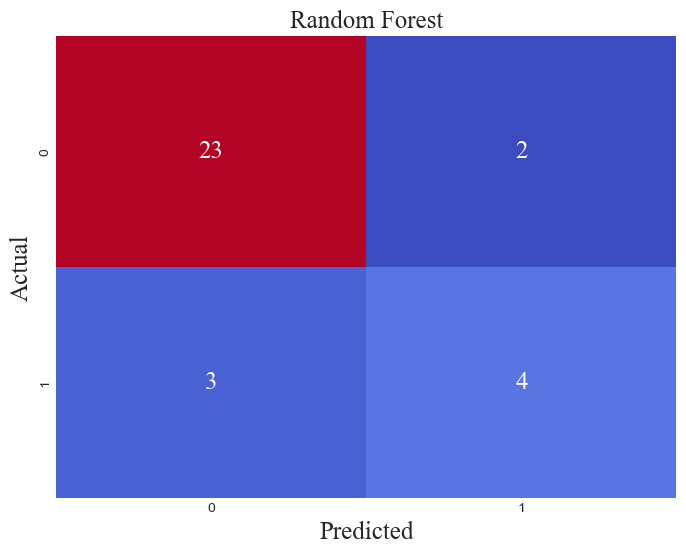

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

font = 'Times New Roman'
size = 18

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Set the style to a modern style
plt.style.use('seaborn-darkgrid')

# Create a custom diverging color map
colors = sns.color_palette("coolwarm", as_cmap=True)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=colors, cbar=False,
            annot_kws={'fontname': font, 'fontsize': size})  # Set font and size for numbers
plt.title('Random Forest', fontname=font, fontsize=size)
plt.xlabel('Predicted', fontname=font, fontsize=size)
plt.ylabel('Actual', fontname=font, fontsize=size)

plt.show()

# For a hyperparameter table 

In [23]:
import pandas as pd
from sklearn.model_selection import ParameterGrid, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone

# Define the parameter grid
param_grid = {
    'm__n_estimators': [100, 200, 300],
    'm__class_weight': [{0: 0.6428571428571429, 1: 2.25}, None],
    'm__max_depth': [None, 10, 20],
    's__n_features_to_select': [5, 1, 15]
}

# Create the pipeline
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
model = RandomForestClassifier()
pipeline = Pipeline(steps=[('s', rfe), ('m', model)])

# Outer cross-validation
outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

# Initialize a DataFrame to store the results
results_df = pd.DataFrame()

# Iterate through each combination of parameters
for params in ParameterGrid(param_grid):
    # Set the parameters of the pipeline
    pipeline.set_params(**params)
    
    # Collect results for each fold
    fold_results = []
    for train_idx, test_idx in outer_cv.split(X_train_res, y_train_res):
        X_train, X_test = X_train_res.iloc[train_idx], X_train_res.iloc[test_idx]
        y_train, y_test = y_train_res[train_idx], y_train_res[test_idx]
        
        # Clone the pipeline to ensure independence
        clf = clone(pipeline)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        # Collect classification report and accuracy
        report = classification_report(y_test, y_pred, output_dict=True)
        accuracy = accuracy_score(y_test, y_pred)
        
        # Append results to the fold_results
        fold_results.append({'params': params, 'accuracy': accuracy, 'report': report})
    
    # Average the results over the folds
    avg_accuracy = sum(result['accuracy'] for result in fold_results) / len(fold_results)
    
    # Handle averaging of the classification report
    avg_report = {}
    avg_precision = 0
    avg_recall = 0
    avg_f1_score = 0
    for label in fold_results[0]['report']:
        if isinstance(fold_results[0]['report'][label], dict):
            avg_report[label] = {
                metric: sum(fold_result['report'][label][metric] for fold_result in fold_results) / len(fold_results)
                for metric in fold_results[0]['report'][label]
            }
            if label == 'weighted avg':
                avg_precision = avg_report[label]['precision']
                avg_recall = avg_report[label]['recall']
                avg_f1_score = avg_report[label]['f1-score']
        else:
            avg_report[label] = sum(fold_result['report'][label] for fold_result in fold_results) / len(fold_results)
    
    # Add the results to the DataFrame using pd.concat
    new_row = pd.DataFrame({
        'params': [params], 
        'accuracy': [avg_accuracy], 
        'precision': [avg_precision], 
        'recall': [avg_recall], 
        'f1-score': [avg_f1_score], 
        'report': [avg_report]
    })
    results_df = pd.concat([results_df, new_row], ignore_index=True)

# Save the results to a CSV file
results_df.to_csv('/Users/dionnespaltman/Desktop/V4/hyperparameters/grid_search_results.csv', index=False)

# Print the results
print(results_df)

KeyboardInterrupt: 